In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

In [2]:
EARLY_STOPPING_PATIENCE = 15


TARGET_PHONEMES_MAX = 10

In [3]:
# check if GPU support
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [4]:
import os
import sys
import pprint
import difflib
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K # beware of .python. here
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Conv2D, Dense, Flatten, Input, 
                                     TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Reshape)
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.backend import ctc_batch_cost, ctc_decode

In [5]:
!pip -q install watermark
import watermark
%load_ext watermark
%watermark --iversions

sklearn          0.22.1
seaborn          0.9.0
pandas           0.25.1
watermark        1.8.1
numpy            1.17.4
tensorflow       2.2.0-dev20200331
tensorflow.keras 2.2.4-tf
matplotlib       3.0.3



In [6]:
''' Remove an index from a dictionary.
'''


def copy_and_remove_symbols(symbol_dict, symbols):
    symbol_dict2 = symbol_dict.copy()
    for key in symbols:
        if key in symbol_dict2:
            del symbol_dict2[key]
    return symbol_dict2

In [7]:
df = pd.read_csv('fr_wiktionary_full.csv', sep='\t')
df = df[df.Audio != '-']
df.head()

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
0,-abilité,a.bi.li.te,False,suffixe,[],True,-,-
1,-able,abl,False,suffixe,[],True,-,-
2,-ac,ak,False,suffixe,[],True,-,-
3,-acanthe,a.kɑ̃t,False,suffixe,[],True,-,-
4,-ace,as,False,suffixe,[],True,-,-


In [8]:
df.shape

(1206333, 8)

In [10]:
PHONEMES = [
        # Voyelles
        'i','e','ɛ','a','ɑ','ɔ','o','u','y','ø','œ','ə','ɛ̃','ɑ̃','ɔ̃','œ̃',
        # Semi-consonnes
        'j','w','ɥ', 
        # Consonnes
        'p','t','k','b','d','ɡ','f','s','ʃ','v','z','ʒ','l','ʁ','m','n','ɲ','ŋ',
    ]
    
def print_phonemes():
    i = 0 
    for i in range(len(PHONEMES) + 2):
        if i == 0:
            print("' 0")
        elif i == 1:
            print('<SPACE> 1')
        else:
            print('%s %d' % (PHONEMES[i-2], i))

In [11]:
# Skip samples whose pronunciation contains unknown phonemes
df = df[~df['Prononciation'].isin(PHONEMES)]

In [12]:
df.shape

(1206153, 8)

In [13]:
df.Prononciation.str.len().max()

27

In [14]:
df[df.Mot=='tonton']

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
1113969,tonton,tɔ̃.tɔ̃,False,nom,['LL-Q150 (fra)-WikiLucas00-tonton.wav'],True,-,-


In [15]:
char_map_str = """
' 0
<SPACE> 1
i 2
e 3
ɛ 4
a 5
ɑ 6
ɔ 7
o 8
u 9
y 10
ø 11
œ 12
ə 13
ɛ̃ 14
ɑ̃ 15
ɔ̃ 16
œ̃ 17
j 18
w 19
ɥ 20
p 21
t 22
k 23
b 24
d 25
ɡ 26
f 27
s 28
ʃ 29
v 30
z 31
ʒ 32
l 33
ʁ 34
m 35
n 36
ɲ 37
ŋ 38
"""

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

In [16]:
def get_phonemes(pronuncation):
    
    phonemes = []
    for i in range(len(pronuncation)):
        if i < len(pronuncation) - 1:
            if pronuncation[i]=='̃':
                continue
            if pronuncation[i+1]=='̃':
                if pronuncation[i] == 'ɑ':
                    phoneme = 'ɑ̃'
                elif pronuncation[i] == 'ɔ':
                    phoneme = 'ɔ̃'
                elif pronuncation[i] == 'œ':
                    phoneme = 'œ̃'
                elif pronuncation[i] == 'ɛ':
                    phoneme = 'ɛ̃'
                else:
                    print('can not happen c=%s' % c)
            else:
                phoneme = pronuncation[i]
        else:
            if pronuncation[i]=='̃':
                continue
            else: 
                phoneme = pronuncation[i]
        phonemes.append(phoneme)
    return phonemes

def get_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_phonemes(pronunciation)    
    # pad list of phonemes
    for i in range(len(padded_phonemes), str_len_max):
        padded_phonemes.append("'")
    return padded_phonemes

def get_tk_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_padded_phonemes(pronunciation, str_len_max)
    tk_padded_phonemes = []
    # tokenize each phoneme
    for phoneme in padded_phonemes:
        tk_padded_phonemes.append(char_map[phoneme])
    
    nb = len(padded_phonemes)
    np_array = np.array(tk_padded_phonemes).reshape(1, nb)
    
    return np_array
    
assert get_phonemes('tɛ̃bʁ') == ['t', 'ɛ̃', 'b', 'ʁ']
assert get_phonemes('tɔ̃tɔ̃') == ['t', 'ɔ̃', 't', 'ɔ̃']
assert get_padded_phonemes('tɛ̃bʁ', 6) == ['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]
assert np.array_equal(get_tk_padded_phonemes('tɛ̃bʁ', 6), np.array([[22, 14, 24, 34,  0,  0]]))

In [17]:
def get_audio_files_names(audio_files_str, verbose=False):
    if verbose:
        print('audio_files=*%s*' % audio_files_str)
    if audio_files_str == '[]':
        if verbose:
            print('empty list')
        audio_file_names = []
    else:
        files_string = audio_files_str[2:-2] + '\', \''
        audio_file_names = files_string.split('\', \'')
        audio_file_names = audio_file_names[:-1]
        if verbose:
            for f in audio_file_names:
                print('file=%s' % f)
    return audio_file_names

assert get_audio_files_names("[]") == []
assert get_audio_files_names("['a.wav']") == ['a.wav']
assert get_audio_files_names("['a.wav', 'b.wav', 'c.wav']") == ['a.wav', 'b.wav', 'c.wav']

In [18]:
AUDIO_DIR = 'audio/'
TIME_MAX = 2.0
MFCC_DIR = 'mfcc_' + str(TIME_MAX) + '/'

allowed_IPA_letters = [
            'a', 'b', 'd', 'e', 'f', 'i', 'j', 'k', 'l', 
            'm', 'n', 'o','p', 's', 't', 'u', 'v', 'w', 'y', 
            'z', 'ø', 'ŋ', 'œ', 'ɑ', 'ɔ', 'ə', 'ɛ', 'ɡ', 'ɥ',
            'ɲ', 'ʁ', 'ʃ', 'ʒ', '̃'   
]

''' Retrieve the dataset 
'''
def get_data(df, n_max=1000000, verbose=False):

    global TARGET_PHONEMES_MAX
    bad_letters = {}
    
    mfcc_max=sys.float_info.min
    mfcc_min=sys.float_info.max     
    
    #df = pd.read_csv('fr_wiktionary_waves.csv', sep='\t')
    df = df[df.Audio != '-']
    indexes_to_drop = []
    
    # reindex the dataframe by the Pronunciation column lenght
    #s = df.Prononciation.str.len().sort_values(ascending=True).index
    #df = df.reindex(s)
    #df = df.sample(frac=1).reset_index(drop=True)
    
    df = df[df.Prononciation.str.len() <= TARGET_PHONEMES_MAX]
    print('df.shape:%d (with len(prononciation)<%d)' % (df.shape[0], TARGET_PHONEMES_MAX))
    # clean pronunciation
    # rows having a pronnuciation with "bad" caracter will be dropped from the df
    for index, row in df.iterrows():
        prononciation = row['Prononciation']
        prononciation = prononciation.replace('(','').replace(')','').replace('‿','').\
        replace('.','').replace(' ','').replace('͡','').replace('-','').replace('ˈ','')
        #prononciation = merge_nasals(prononciation)
        for phoneme in prononciation:            
            if phoneme not in allowed_IPA_letters:
                if phoneme not in bad_letters.keys():
                    bad_letters[phoneme] = 0
                bad_letters[phoneme] += 1
                indexes_to_drop.append(index)
                break
        df.at[index, 'Prononciation'] = prononciation
            
    print('bad_letters=', bad_letters)
    df = df.drop(indexes_to_drop)
    
    # read all mfcc file to learn the maximum shape of the samples
    mfcc_shape_t = 0
    for index, row in df.iterrows():

        #wav_files = get_audio_files_names(row['Audio'])
        #for wav_file in wav_files:
        #    if 'WikiLucas' in wav_file:
                
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'])
        for wav_file in wav_files:
            if 'WikiLucas' in wav_file:
                mfcc_file = wav_file.replace('.wav','.npy').replace(' ','_')                
                mfcc_filename = MFCC_DIR + mfcc_file
                if os.path.exists(mfcc_filename):
                    mfcc = np.load(mfcc_filename)
                    mfcc_shape_t = max(mfcc_shape_t, mfcc.shape[1])
                    mfcc_shape_d = mfcc.shape[0]
                    break
    n=0
    n_ko=0
    print('mfcc_shape_t:%d', mfcc_shape_t)
    # numpy shapes to be ready to be used as inputs and targets
    mfccs = np.zeros((n_max, mfcc_shape_t, mfcc_shape_d))
    phonemess = np.zeros((n_max, TARGET_PHONEMES_MAX))
    mots = []
    prononciations = []
    
    for index, row in df.sample(df.shape[0]).iterrows():                
        
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'])
        for wav_file in wav_files:
            if not 'WikiLucas' in wav_file:
                continue
            else:
                mfcc_file = wav_file.replace('.wav','.npy').replace(' ','_')
                break
        
        if mfcc_file == '':
            continue
        
        mfcc_filename = MFCC_DIR + mfcc_file
        if os.path.exists(mfcc_filename):
            mfcc = np.load(mfcc_filename)
            if verbose:            
                print('mfcc.shape:', mfcc.shape)
            
            if mfcc[-1][-1] != 0.0:
                try:
                    print('pb for %s' % row['Wav_file'])
                except:
                    print('#')
                continue
            
            # add the mfcc in the mfccs table
            mfccs[n,:,:] = mfcc.transpose()[:,:]
        
            # fetch the prononciation
            mot = row['Mot']
            prononciation = row['Prononciation']
            phonemes = get_tk_padded_phonemes(prononciation, TARGET_PHONEMES_MAX)
            # add the mfcc in the mfccs table
            phonemess[n,:] = phonemes
            mots.append(mot)
            prononciations.append(prononciation)
            n += 1
            if n>n_max-1:
                break
        else:
            n_ko+=1
            
    print('n:',n)
    print('n_ko:',n_ko)
    #mfccs = (mfccs - mfccs.min()) / (mfccs.max() - mfccs.min())
    #mfccs = mfccs - mfccs.mean()
    #mfccs = mfccs.astype(int)
    print('mfccs.shape:', mfccs.shape)
        
    return n, mfccs, phonemess, prononciations, mots

In [19]:
#%time mfccs, phonemes, prononciations, mots = get_data(df, NB_TRAINING_SAMPLES+NB_TEST_SAMPLES, verbose=False)    
#%time n, mfccs, phonemes, prononciations, mots = get_data(df, n_max=238685)    
%time n, mfccs, phonemes, prononciations, mots = get_data(df, n_max=9989) 
#%time n, mfccs, phonemes, prononciations, mots = get_data(df, n)    

df.shape:488700 (with len(prononciation)<10)
bad_letters= {}
mfcc_shape_t:%d 87
n: 9989
n_ko: 131
mfccs.shape: (9989, 87, 40)
CPU times: user 1min 51s, sys: 452 ms, total: 1min 52s
Wall time: 1min 52s


In [20]:
NB_TEST_SAMPLES = 100
NB_TRAINING_SAMPLES = n - NB_TEST_SAMPLES
print('NB_TRAINING_SAMPLES:%d' % NB_TRAINING_SAMPLES)
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

NB_TRAINING_SAMPLES:9889
NB_TEST_SAMPLES:100


In [21]:
phonemes.shape

(9989, 10)

In [22]:
mfccs.shape

(9989, 87, 40)

In [23]:
len(mots)

9989

In [24]:
X_train = mfccs[0:NB_TRAINING_SAMPLES,]
Y_train = phonemes[0:NB_TRAINING_SAMPLES]
X_test = mfccs[NB_TRAINING_SAMPLES:,]
Y_test = phonemes[NB_TRAINING_SAMPLES:]

In [25]:
x_train_mean = X_train.mean()
x_train_std = X_train.std()
X_train -= x_train_mean
X_train /= x_train_std

In [26]:
X_test -= x_train_mean
X_test /= x_train_std

In [27]:
# Actual loss calculation
def ctc_lambda_func(args):
  y_pred, labels, input_length, label_length = args
  # From Keras example image_ocr.py:
  # the 2 is critical here since the first couple outputs of the RNN
  # tend to be garbage:
  #y_pred = y_pred[:, 2:, :]
  y_pred = y_pred[:, :, :]
  return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [28]:
# Input tensor for sequences of 46 timesteps,
# each containing a 40-dimensional vector

class MyModel(object):

    # CTC Layer implementation using Lambda layer
    # (because Keras doesn't support extra prams on loss function)
    def CTC(self, name, args):
        return Lambda(ctc_lambda_func, output_shape=(1,), name=name)(args)
 
    def __init__(self, D, max_string_len, C, T, conv = '1D'):
        print('D=%d, max_string_len=%d, C=%d' % (D, max_string_len, C))
        
        
        filters = 512
        units = filters
        kernel_size_1d = 3
        kernel_size_2d = (3,3)
        conv_stride = 1 #3
        conv_border_mode = 'same'#'valid'
                  
        if conv == '1D':
            self.input_data = Input(name='the_input', shape=(None, D), dtype='float32') #D=40
            
            self.conv_1d_01 = Conv1D(filters, kernel_size_1d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_1d_01')(self.input_data)

            self.bn_01_layer = BatchNormalization(name='bn_01_layer')(self.conv_1d_01)

            self.conv_1d_02 = Conv1D(filters, kernel_size_1d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_1d_02')(self.bn_01_layer)

            self.bn_02_layer = BatchNormalization(name='bn_02_layer')(self.conv_1d_02)

        elif conv == '2D':
            self.input_data = Input(name='the_input', shape=(T, D, 1), dtype='float32') #D=40
        
            self.conv_2d_01 = Conv2D(filters, kernel_size_2d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_2d_01')(self.input_data)

            self.bn_01_layer = BatchNormalization(name='bn_01_layer')(self.conv_2d_01)

            self.conv_2d_02 = Conv2D(filters, kernel_size_2d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_2d_02')(self.bn_01_layer)

            self.bn_02_layer = BatchNormalization(name='bn_02_layer')(self.conv_1d_02)

            self.bn_02_layer = Flatten()(self.bn_02_layer)        
            self.bn_02_layer = Reshape((-1, D))(self.bn_022_layer)
            self.bn_02_layer = TimeDistributed(Dense(D), name="td000")(self.bn_02_layer)
            
        else:
            print('conv_type=%s not supported' % conv_tpye)
            
        rnn0 = keras.layers.LSTM(units, return_sequences=True, dropout=0.1, name="rnn")
        self.bidir_rnn1 = Bidirectional(rnn0, name='bidir_rnn_1_layer')(self.bn_02_layer)
        
        self.bn_1 = BatchNormalization(name='bn_1_layer')(self.bidir_rnn1)
        
        rnn = keras.layers.LSTM(units, return_sequences=True, dropout=0.1, name="rnn2")
        self.bidir_rnn2 = Bidirectional(rnn, name='bidir_rnn_2_layer')(self.bn_1)
        
        self.bn_2 = BatchNormalization(name='bn_2_layer')(self.bidir_rnn2)
        
        self.outputs = TimeDistributed(Dense(C), name="td")(self.bidir_rnn2)
        
        self.y_pred = Activation('softmax', name='softmax')(self.outputs)

        self.labels = Input(name='the_labels', shape=[max_string_len], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')

        self.loss_out = self.CTC('ctc', [self.y_pred, self.labels, self.input_length, self.label_length])

        self.model = Model(inputs=[self.input_data, self.labels, self.input_length, self.label_length], outputs=self.loss_out)

        
        #self.model.output_length = lambda x: cnn_output_length(x, kernel_size, conv_border_mode, conv_stride)
        
        self.model.summary()

        #adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        adam = Adam()
        self.model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam)

    def fit(self, X_train, Y_train, input_length, label_length, loss, epochs, 
            batch_size, callbacks, validation_split, verbose):
      history = self.model.fit([X_train, Y_train, input_length, label_length], loss, 
                               epochs=epochs, batch_size=batch_size, 
                               callbacks=callbacks,
                               validation_split=validation_split, verbose=verbose, )
      return history 
      
    def predict(self, input_batch):
        return self.test_function([input_batch, True])[0]  # the first 0 indicates test

    @property
    def test_function(self):
        # captures output of softmax so we can decode the output during visualization
        #return K.function([self.input_data, K.symbolic_learning_phase()], [self.y_pred, K.symbolic_learning_phase()])
        return K.function([self.input_data, K.symbolic_learning_phase()], [self.y_pred, K.symbolic_learning_phase()])

In [29]:
# outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
#input_length = X_train.shape[1]
#print('input_length', input_length)

print('X_train.shape', X_train.shape)
print('Y_train.shape', Y_train.shape)
      
N = NB_TRAINING_SAMPLES
T = mfccs.shape[1]
print('T:%d', T)
D = mfccs.shape[2]
print('D:%d', D)

input_length = np.zeros([N])
for i in range(N):
    input_length[i] = T
print('input_length[0:2]:', input_length[0:2])
print('input_length.shape', input_length.shape)

label_length = np.zeros([N])
for i in range(N):
    label_length[i] = TARGET_PHONEMES_MAX
print('label_length[0:2]:', label_length[0:2])

#print('input_length.shape', input_length.shape)

loss = np.zeros([N])

print('loss.shape[0:2]', loss.shape[0:2])


C = len(char_map.keys()) + 1
print('C=nb_ipa_letters=%d' % C)




X_train.shape (9889, 87, 40)
Y_train.shape (9889, 10)
T:%d 87
D:%d 40
input_length[0:2]: [87. 87.]
input_length.shape (9889,)
label_length[0:2]: [10. 10.]
loss.shape[0:2] (9889,)
C=nb_ipa_letters=40


In [30]:
mmodel = MyModel(D, TARGET_PHONEMES_MAX, C, T)

D=40, max_string_len=10, C=40
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, None, 40)]   0                                            
__________________________________________________________________________________________________
conv_1d_01 (Conv1D)             (None, None, 512)    61952       the_input[0][0]                  
__________________________________________________________________________________________________
bn_01_layer (BatchNormalization (None, None, 512)    2048        conv_1d_01[0][0]                 
__________________________________________________________________________________________________
conv_1d_02 (Conv1D)             (None, None, 512)    786944      bn_01_layer[0][0]                
________________________________________________________________

In [31]:
def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

In [32]:
print('X_train.shape', X_train.shape)

X_train.shape (9889, 87, 40)


In [33]:
#import sys
#import numpy
#numpy.set_printoptions(threshold=sys.maxsize)

In [34]:
#X_train[6000:6001]

In [35]:
Y_train[0:1]

array([[ 5., 24.,  4., 22.,  2., 34.,  0.,  0.,  0.,  0.]])

In [36]:
mots[0]

'abêtir'

In [37]:
prononciations[0]

'abɛtiʁ'

In [38]:
callbacks_list = [
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=10,
            restore_best_weights=True,
        ),
    ]

In [39]:
history = mmodel.fit(X_train, Y_train, input_length, label_length, loss, epochs=200, batch_size=32, callbacks=callbacks_list, validation_split=0.1, verbose=True)

Epoch 1/200
279/279 [==============================] - 19s 68ms/step - loss: 16.1745 - val_loss: 37.0067
Epoch 2/200
279/279 [==============================] - 17s 62ms/step - loss: 5.9134 - val_loss: 6.6803
Epoch 3/200
279/279 [==============================] - 18s 65ms/step - loss: 3.9142 - val_loss: 3.8360
Epoch 4/200
279/279 [==============================] - 17s 62ms/step - loss: 3.0441 - val_loss: 3.8626
Epoch 5/200
279/279 [==============================] - 17s 61ms/step - loss: 2.4585 - val_loss: 3.1989
Epoch 6/200
279/279 [==============================] - 17s 61ms/step - loss: 2.2218 - val_loss: 5.1616
Epoch 7/200
279/279 [==============================] - 17s 62ms/step - loss: 1.7700 - val_loss: 2.8604
Epoch 8/200
279/279 [==============================] - 17s 62ms/step - loss: 1.4820 - val_loss: 2.7655
Epoch 9/200
279/279 [==============================] - 17s 62ms/step - loss: 1.3094 - val_loss: 2.7990
Epoch 10/200
279/279 [==============================] - 17s 62ms/step -

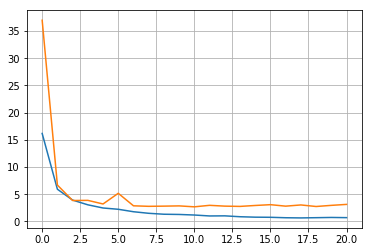

In [40]:
_ = plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.show()

In [41]:
X_test.shape

(100, 87, 40)

In [42]:
# test NB_TEST_SAMPLES samples
res = mmodel.predict(X_test[0:NB_TEST_SAMPLES])

In [43]:
res.shape

(100, 87, 40)

In [44]:
s = K.ctc_decode(y_pred=res, input_length=input_length[0:res.shape[0]], greedy=True)
#print(s)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [46]:
from IPython.display import Markdown
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

n_tested = 0
n_ok = 0
n_ko = 0
results = np.asarray(s[0][0])
debug_str = '[MOT] /PRONONCIATION WIKTIONNAIRE/ vs /PPRONONCIATION PREDITE/<br>'
for i in range(NB_TEST_SAMPLES):
    phonemes = ''
    mot = mots[NB_TRAINING_SAMPLES + i]
    prononciation = prononciations[NB_TRAINING_SAMPLES + i]
    debug_str += '[' + mot + '] /' + prononciation + '/ vs '
    for letter in range(results.shape[1]):
        val = results[i, letter]
        if val == -1:
            continue
        phoneme = index_map[val+1]
        #print('r=',results[n,letter],end=',')
        phonemes += phoneme
    phonemes = phonemes.replace("\'",'')
    debug_str += '/' + phonemes + '/'
    n_tested += 1
    if phonemes == prononciation:
        debug_str += ': <span style="color: #00ff00">ok</span><br>'
        n_ok += 1
    else:
        debug_str += ': <span style="color: #ff0000">ko</span><br>'  
        n_ko += 1
display (Markdown(debug_str))
        
print('n_tested:%d, n_ok:%d, n_ko:%d' % (n_tested, n_ok, n_ko))

[MOT] /PRONONCIATION WIKTIONNAIRE/ vs /PPRONONCIATION PREDITE/<br>[ressortir] /ʁəsɔʁtiʁ/ vs /ʁəsɔʁtiʁ/: <span style="color: #00ff00">ok</span><br>[téléthèse] /teletɛz/ vs /ʁeetɛz/: <span style="color: #ff0000">ko</span><br>[abstrait] /apstʁɛ/ vs /akstʁɛ/: <span style="color: #ff0000">ko</span><br>[celation] /səlasjɔ̃/ vs /slasjɔ̃/: <span style="color: #ff0000">ko</span><br>[assécher] /aseʃe/ vs /aseʃe/: <span style="color: #00ff00">ok</span><br>[fusiller] /fuzije/ vs /fyzje/: <span style="color: #ff0000">ko</span><br>[feu] /fø/ vs /fl/: <span style="color: #ff0000">ko</span><br>[oit] /wat/ vs /wat/: <span style="color: #00ff00">ok</span><br>[embaucheuse] /ɑ̃boʃøz/ vs /ɑ̃bɔʃøz/: <span style="color: #ff0000">ko</span><br>[commotion] /kɔmɔsjɔ̃/ vs /kosjɔ̃/: <span style="color: #ff0000">ko</span><br>[régresser] /ʁeɡʁɛse/ vs /ʁeɡʁɛse/: <span style="color: #00ff00">ok</span><br>[celui-ci] /səlɥisi/ vs /səlisi/: <span style="color: #ff0000">ko</span><br>[abîmer] /abime/ vs /abime/: <span style="color: #00ff00">ok</span><br>[acuminé] /akymine/ vs /akymine/: <span style="color: #00ff00">ok</span><br>[lunistice] /lynistis/ vs /ynistis/: <span style="color: #ff0000">ko</span><br>[mixtion] /mikstjɔ̃/ vs /mikstjɔ̃/: <span style="color: #00ff00">ok</span><br>[gletter] /ɡlɛte/ vs /ɡlɛte/: <span style="color: #00ff00">ok</span><br>[regeeker] /ʁəɡike/ vs /ʁəɡike/: <span style="color: #00ff00">ok</span><br>[survirer] /syʁviʁe/ vs /syʁviʁe/: <span style="color: #00ff00">ok</span><br>[pileuse] /piløz/ vs /piløz/: <span style="color: #00ff00">ok</span><br>[bischof] /biʃɔf/ vs /biʃɔf/: <span style="color: #00ff00">ok</span><br>[concourir] /kɔ̃kuʁiʁ/ vs /kɔ̃kuʁiʁ/: <span style="color: #00ff00">ok</span><br>[balayeur] /balɛjœʁ/ vs /balɛjœʁ/: <span style="color: #00ff00">ok</span><br>[brichauder] /bʁiʃode/ vs /bʁiʃode/: <span style="color: #00ff00">ok</span><br>[suer] /sɥe/ vs /sɥe/: <span style="color: #00ff00">ok</span><br>[tictacquer] /tiktake/ vs /tiktake/: <span style="color: #00ff00">ok</span><br>[vendeuse] /vɑ̃døz/ vs /vɑ̃døz/: <span style="color: #00ff00">ok</span><br>[marqueuse] /maʁkøz/ vs /maʁkøz/: <span style="color: #00ff00">ok</span><br>[livre] /livʁ/ vs /livʁ/: <span style="color: #00ff00">ok</span><br>[nu] /ny/ vs /ny/: <span style="color: #00ff00">ok</span><br>[circuiter] /siʁkɥite/ vs /siʁkɥite/: <span style="color: #00ff00">ok</span><br>[teube] /tœb/ vs /təb/: <span style="color: #ff0000">ko</span><br>[gueules] /ɡœl/ vs /ɡl/: <span style="color: #ff0000">ko</span><br>[râpé] /ʁape/ vs /ʁape/: <span style="color: #00ff00">ok</span><br>[rigidement] /ʁiʒidmɑ̃/ vs /ʁiʒidmɑ̃/: <span style="color: #00ff00">ok</span><br>[accordeuse] /akɔʁdøz/ vs /akɔʁdøz/: <span style="color: #00ff00">ok</span><br>[tièdement] /tjɛdmɑ̃/ vs /tjɛdmɑ̃/: <span style="color: #00ff00">ok</span><br>[métalleuse] /metaløz/ vs /metaløz/: <span style="color: #00ff00">ok</span><br>[récriveuse] /ʁekʁivøz/ vs /ʁekivøz/: <span style="color: #ff0000">ko</span><br>[fadet] /fadɛt/ vs /fade/: <span style="color: #ff0000">ko</span><br>[raffermir] /ʁafɛʁmiʁ/ vs /ʁafɛʁmiʁ/: <span style="color: #00ff00">ok</span><br>[accouardir] /akwaʁdiʁ/ vs /akwaʁdiʁ/: <span style="color: #00ff00">ok</span><br>[pays] /pei/ vs /pɛi/: <span style="color: #ff0000">ko</span><br>[télescope] /teleskɔp/ vs /tenɛskɔp/: <span style="color: #ff0000">ko</span><br>[chaise] /ʃɛz/ vs /kaɛz/: <span style="color: #ff0000">ko</span><br>[initiale] /inisjal/ vs /iisjal/: <span style="color: #ff0000">ko</span><br>[alvéolé] /alveɔle/ vs /aləveɔle/: <span style="color: #ff0000">ko</span><br>[optique] /ɔptik/ vs /pɔptik/: <span style="color: #ff0000">ko</span><br>[mer] /mɛʁ/ vs /bɛʁ/: <span style="color: #ff0000">ko</span><br>[panneau] /pano/ vs /pano/: <span style="color: #00ff00">ok</span><br>[éjectile] /eʒɛktil/ vs /eʒɛktil/: <span style="color: #00ff00">ok</span><br>[foirer] /fwaʁe/ vs /fwaʁe/: <span style="color: #00ff00">ok</span><br>[reswitcher] /ʁəswitʃe/ vs /ʁəswtʃe/: <span style="color: #ff0000">ko</span><br>[ronchemeler] /ʁɔ̃ʃməle/ vs /ʁɔ̃ʃməle/: <span style="color: #00ff00">ok</span><br>[dévoler] /devɔle/ vs /devole/: <span style="color: #ff0000">ko</span><br>[dévêtir] /devɛtiʁ/ vs /devetiʁ/: <span style="color: #ff0000">ko</span><br>[assesseur] /asesœʁ/ vs /asesœʁ/: <span style="color: #00ff00">ok</span><br>[jaleuse] /ʒaløz/ vs /ʒaløz/: <span style="color: #00ff00">ok</span><br>[flonger] /flɔ̃ʒe/ vs /flɔ̃ʒe/: <span style="color: #00ff00">ok</span><br>[cloquer] /klɔke/ vs /klɔke/: <span style="color: #00ff00">ok</span><br>[dessouler] /dɛsule/ vs /deswle/: <span style="color: #ff0000">ko</span><br>[caver] /kave/ vs /kave/: <span style="color: #00ff00">ok</span><br>[prédiseuse] /pʁedizøz/ vs /pʁedizøz/: <span style="color: #00ff00">ok</span><br>[choucrouteuse] /ʃukʁutøz/ vs /ʃukutøz/: <span style="color: #ff0000">ko</span><br>[épinceuse] /epɛ̃søz/ vs /epɛ̃søz/: <span style="color: #00ff00">ok</span><br>[échetiner] /eʃtine/ vs /eʃtine/: <span style="color: #00ff00">ok</span><br>[front] /fʁɔ̃/ vs /fʁɔ̃/: <span style="color: #00ff00">ok</span><br>[rogation] /ʁɔɡasjɔ̃/ vs /ʁɔɡasjɔ̃/: <span style="color: #00ff00">ok</span><br>[bouillir] /bujiʁ/ vs /bujiʁ/: <span style="color: #00ff00">ok</span><br>[acquiesçable] /akjesabl/ vs /atjɛsabl/: <span style="color: #ff0000">ko</span><br>[dracher] /dʁaʃe/ vs /dɔaʃe/: <span style="color: #ff0000">ko</span><br>[chichon] /ʃiʃɔ̃/ vs /ʃiʃɔ̃/: <span style="color: #00ff00">ok</span><br>[bannière] /banjɛʁ/ vs /banjɛʁ/: <span style="color: #00ff00">ok</span><br>[anima] /anima/ vs /adina/: <span style="color: #ff0000">ko</span><br>[prester] /pʁɛste/ vs /pʁɛste/: <span style="color: #00ff00">ok</span><br>[fuster] /fyste/ vs /fyste/: <span style="color: #00ff00">ok</span><br>[guindailler] /ɡɛ̃dɑje/ vs /ɡadɑje/: <span style="color: #ff0000">ko</span><br>[truquer] /tʁyke/ vs /tʁyke/: <span style="color: #00ff00">ok</span><br>[rémanence] /ʁemanɑ̃s/ vs /ʁemanɑ̃s/: <span style="color: #00ff00">ok</span><br>[dormeuse] /dɔʁmøz/ vs /dɔʁmøz/: <span style="color: #00ff00">ok</span><br>[centre] /sɑ̃tʁ/ vs /sɑ̃tʁ/: <span style="color: #00ff00">ok</span><br>[bimoteur] /bimɔtœʁ/ vs /bimwɔtœʁ/: <span style="color: #ff0000">ko</span><br>[chuchoter] /ʃyʃɔte/ vs /ʃʃɔte/: <span style="color: #ff0000">ko</span><br>[regaffer] /ʁəɡafe/ vs /ʁəɡafe/: <span style="color: #00ff00">ok</span><br>[verdaille] /vɛʁdɑj/ vs /nɛʁdajj/: <span style="color: #ff0000">ko</span><br>[blogueur] /blɔɡœʁ/ vs /blɔɡœʁ/: <span style="color: #00ff00">ok</span><br>[pamphile] /pɑ̃fil/ vs /pɔfil/: <span style="color: #ff0000">ko</span><br>[hiberner] /ibɛʁne/ vs /ibɛʁne/: <span style="color: #00ff00">ok</span><br>[sapin] /sapɛ̃/ vs /sapɛ̃/: <span style="color: #00ff00">ok</span><br>[alléger] /alleʒe/ vs /aleʒe/: <span style="color: #ff0000">ko</span><br>[cogneuse] /kɔnjøz/ vs /kɔɲøz/: <span style="color: #ff0000">ko</span><br>[rechiquer] /ʁəʃike/ vs /ʁəʃike/: <span style="color: #00ff00">ok</span><br>[honnêtement] /ɔnɛtmɑ̃/ vs /ɔnɛtmɑ̃/: <span style="color: #00ff00">ok</span><br>[limoner] /limɔne/ vs /limɔne/: <span style="color: #00ff00">ok</span><br>[enclore] /ɑ̃klɔʁ/ vs /ɑ̃klɔʁ/: <span style="color: #00ff00">ok</span><br>[abeillé] /abɛje/ vs /abeje/: <span style="color: #ff0000">ko</span><br>[vaillamment] /vajamɑ̃/ vs /vajamɑ̃/: <span style="color: #00ff00">ok</span><br>[allophone] /alɔfɔn/ vs /alɔfɔn/: <span style="color: #00ff00">ok</span><br>[ancrage] /ɑ̃kʁaʒ/ vs /ɑ̃kʁaʒ/: <span style="color: #00ff00">ok</span><br>[bieurler] /bjœʁle/ vs /bjɔʁle/: <span style="color: #ff0000">ko</span><br>

n_tested:100, n_ok:63, n_ko:37
